# Import Libaray

In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(mice)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ mice::filter() masks dplyr::filter(), stats::filter()
✖ dplyr::lag()   masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching packa

In [2]:
diabetes <- read.csv("data/diabetes.csv")
head(diabetes)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


# Introduction

# Methods and Results

## EDA

In [3]:
# Main developer: Luna 
# view the number of missing values for each variable
missing_values <- colSums(is.na(diabetes))
missing_values 

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

After viewing missing_values, we can see that there are no missing values for any variable.

However, when we viewed some rows with head(diabetes), there were rows with zero values. 
- The presence of zeros in the dataset may indicate placeholders for missing data, as these values of certain health metrics generally shouldn’t be zero in health data, such as Glucose and Insulin; so, it’s reasonable to consider these zeros as placeholders for missing data. 
- If these are left in the model without treatment, it could lead to bias, especially in a logistic regression model sensitive to extreme values, by skewing distributions (i.e. falsely lower Insulin averages) and weaken the model’s predictive power.

Therefore, we can similarly check for such rows:

In [4]:
# Main developer: Luna 
# these columns are measurements which are generally unlikely to have 0 values (for instance unlike Pregnancies)
columns_with_zeros <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")

zero_counts <- colSums(diabetes[columns_with_zeros] == 0)
zero_counts

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

We can now treat these zeros in these key predictor columns as missing values.

I decided to exclude rows with zero values, as these values could distort the analysis.
- _It's worthy to note that a possible issue with this method is that this might reduce our dataset size._

In [5]:
# Main developer: Luna 
# converting the zero values to NA
diabetes2 <- diabetes |>
    mutate_at(vars(all_of(columns_with_zeros)), ~na_if(., 0))

# dropping rows with NA
diabetes_cleaned <- diabetes2 |> drop_na(all_of(columns_with_zeros))
head(diabetes_cleaned)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,1,89,66,23,94,28.1,0.167,21,0
2,0,137,40,35,168,43.1,2.288,33,1
3,3,78,50,32,88,31.0,0.248,26,1
4,2,197,70,45,543,30.5,0.158,53,1
5,1,189,60,23,846,30.1,0.398,59,1
6,5,166,72,19,175,25.8,0.587,51,1


In [6]:
# Main developer: Luna 
# convert Outcome to a factor with levels "0" and "1"
diabetes_cleaned$Outcome <- factor(diabetes_cleaned$Outcome, levels = c(0, 1), labels = c("0", "1"))

# verify and check levels
str(diabetes_cleaned)
levels(diabetes_cleaned$Outcome)

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


[1] "0" "1"

Lastly, viewing summary statistics allows us to gauge potential outliers.

In [7]:
# Main developer: Luna 
summary(diabetes_cleaned)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

In [8]:
# calculate the IQR bounds for each column individually
Q1_bmi <- quantile(diabetes_cleaned$BMI, 0.25, na.rm = TRUE)
Q3_bmi <- quantile(diabetes_cleaned$BMI, 0.75, na.rm = TRUE)
IQR_bmi <- Q3_bmi - Q1_bmi

Q1_bp <- quantile(diabetes_cleaned$BloodPressure, 0.25, na.rm = TRUE)
Q3_bp <- quantile(diabetes_cleaned$BloodPressure, 0.75, na.rm = TRUE)
IQR_bp <- Q3_bp - Q1_bp

Q1_glucose <- quantile(diabetes_cleaned$Glucose, 0.25, na.rm = TRUE)
Q3_glucose <- quantile(diabetes_cleaned$Glucose, 0.75, na.rm = TRUE)
IQR_glucose <- Q3_glucose - Q1_glucose

Q1_insulin <- quantile(diabetes_cleaned$Insulin, 0.25, na.rm = TRUE)
Q3_insulin <- quantile(diabetes_cleaned$Insulin, 0.75, na.rm = TRUE)
IQR_insulin <- Q3_insulin - Q1_insulin

# filter rows based on the IQR bounds for each column
diabetes_clean <- diabetes_cleaned %>%
  filter(Glucose >= (Q1_glucose - 1.5 * IQR_glucose) & Glucose <= (Q3_glucose + 1.5 * IQR_glucose),
         BloodPressure >= (Q1_bp - 1.5 * IQR_bp) & BloodPressure <= (Q3_bp + 1.5 * IQR_bp),
         Insulin >= (Q1_insulin - 1.5 * IQR_insulin) & Insulin <= (Q3_insulin + 1.5 * IQR_insulin),
         BMI >= (Q1_bmi - 1.5 * IQR_bmi) & BMI <= (Q3_bmi + 1.5 * IQR_bmi))

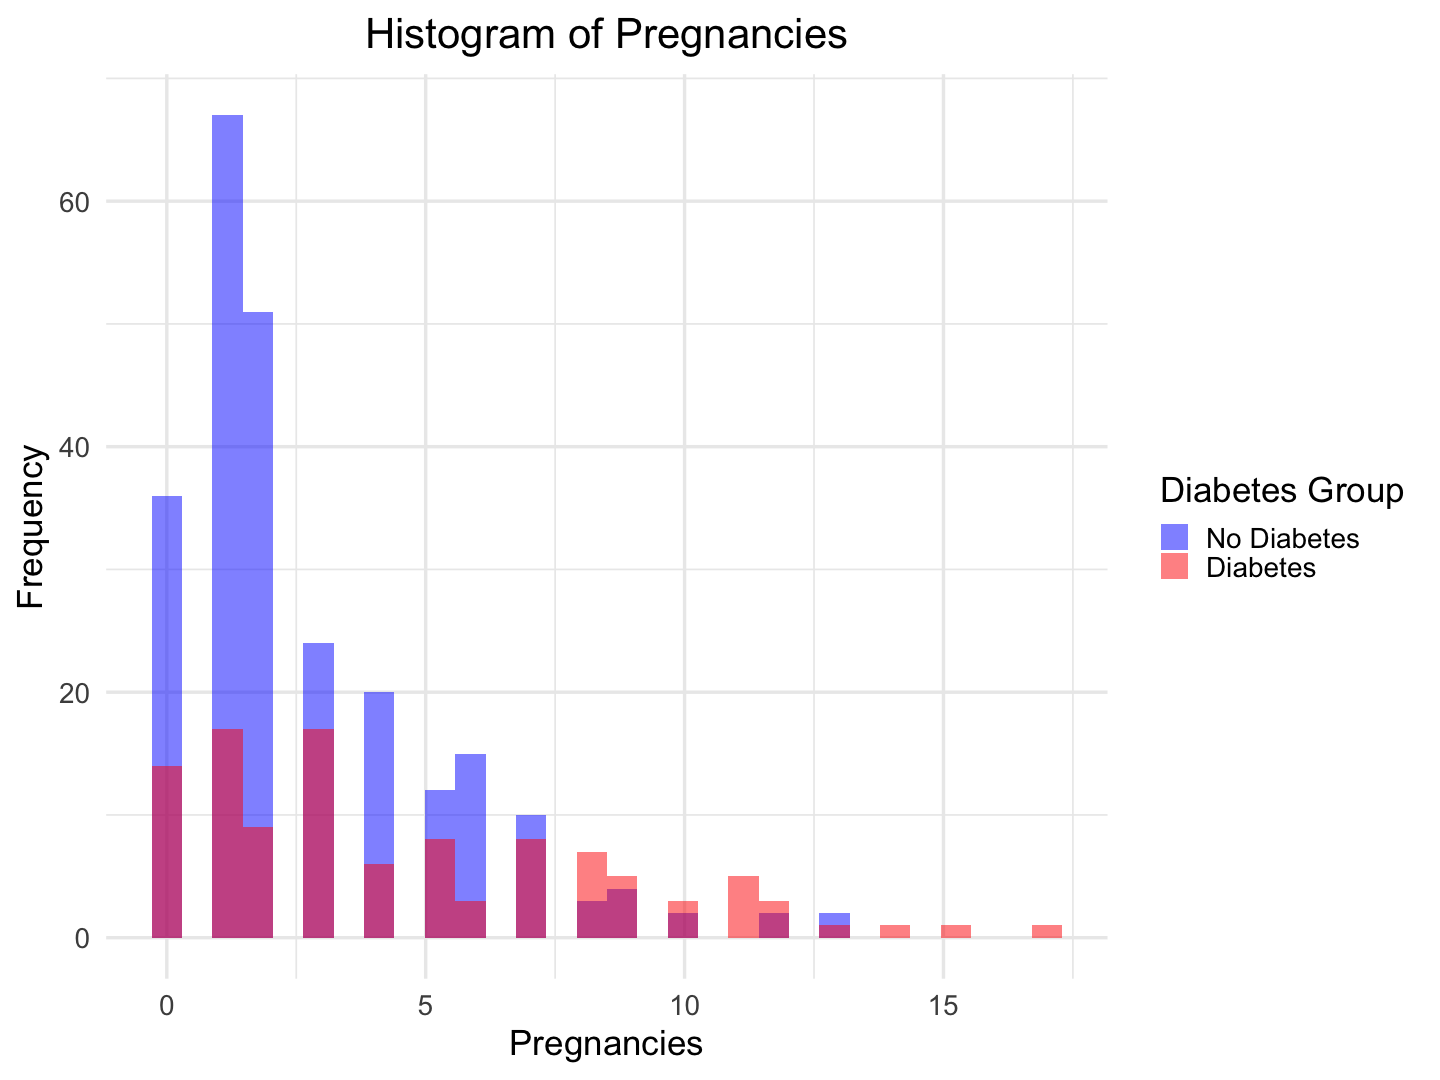

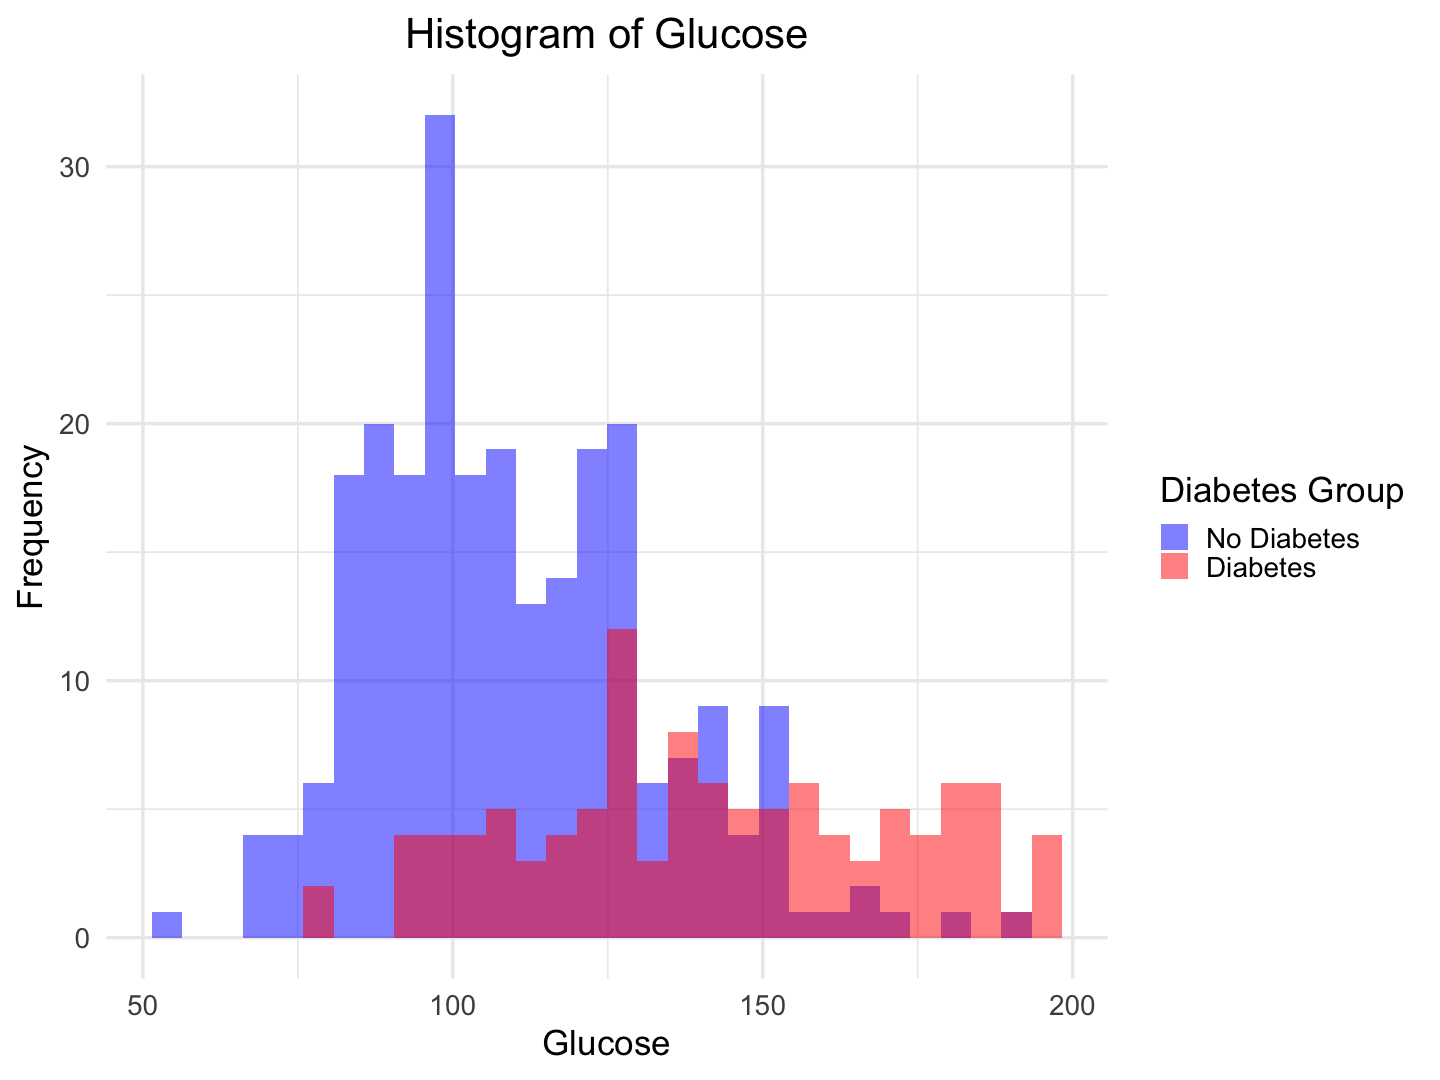

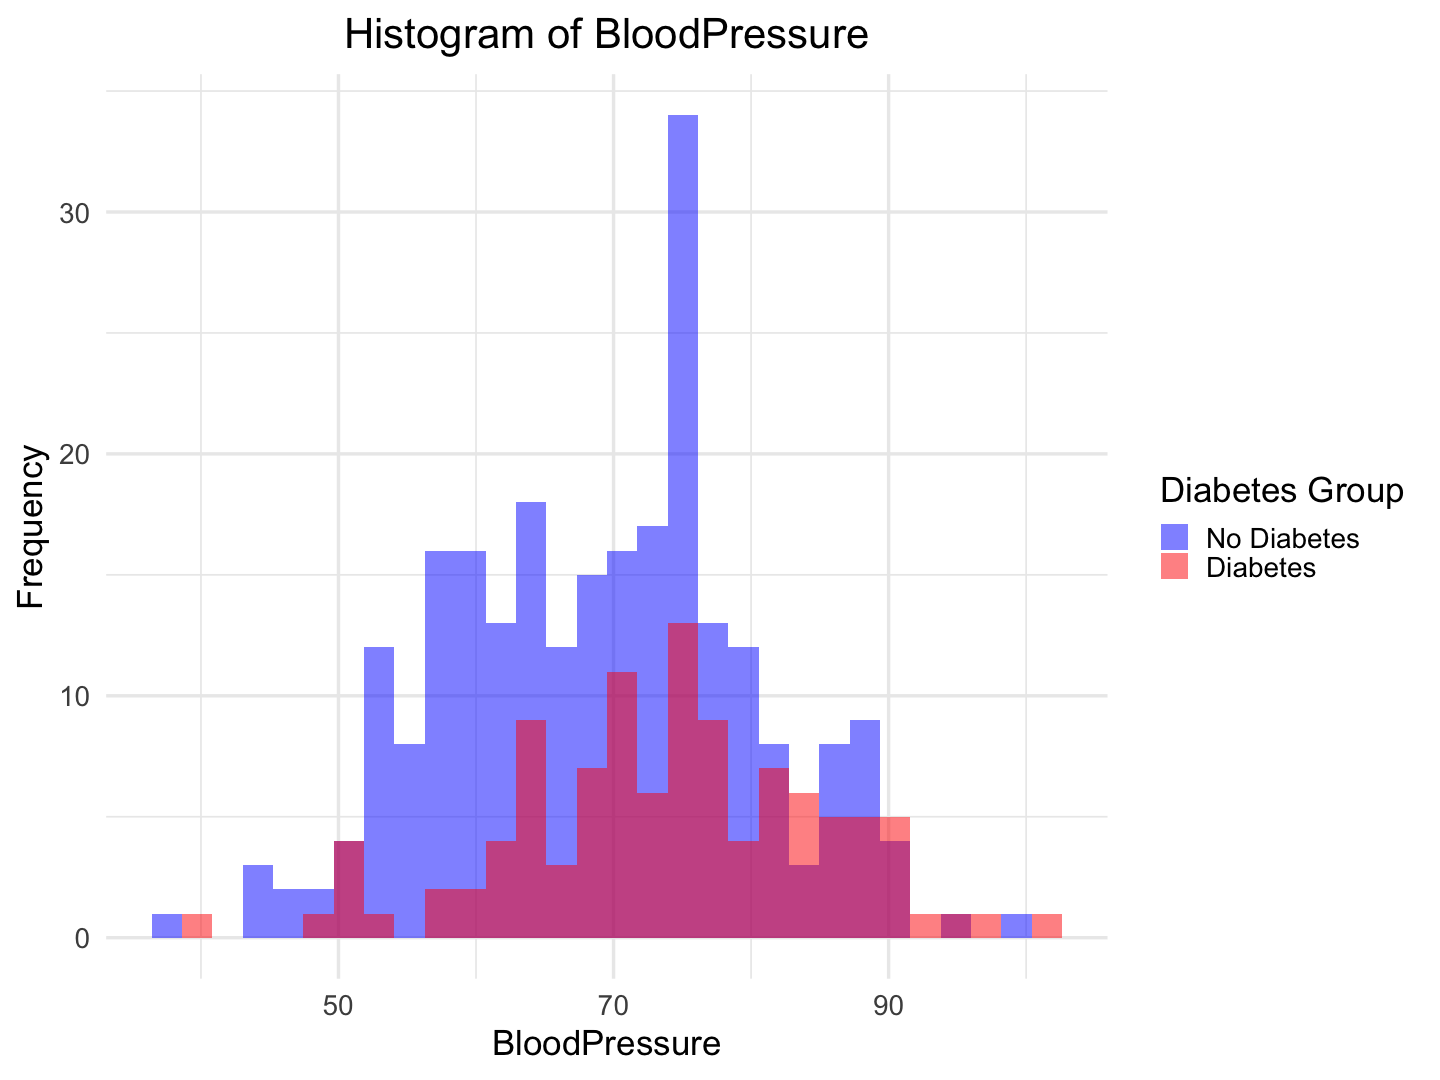

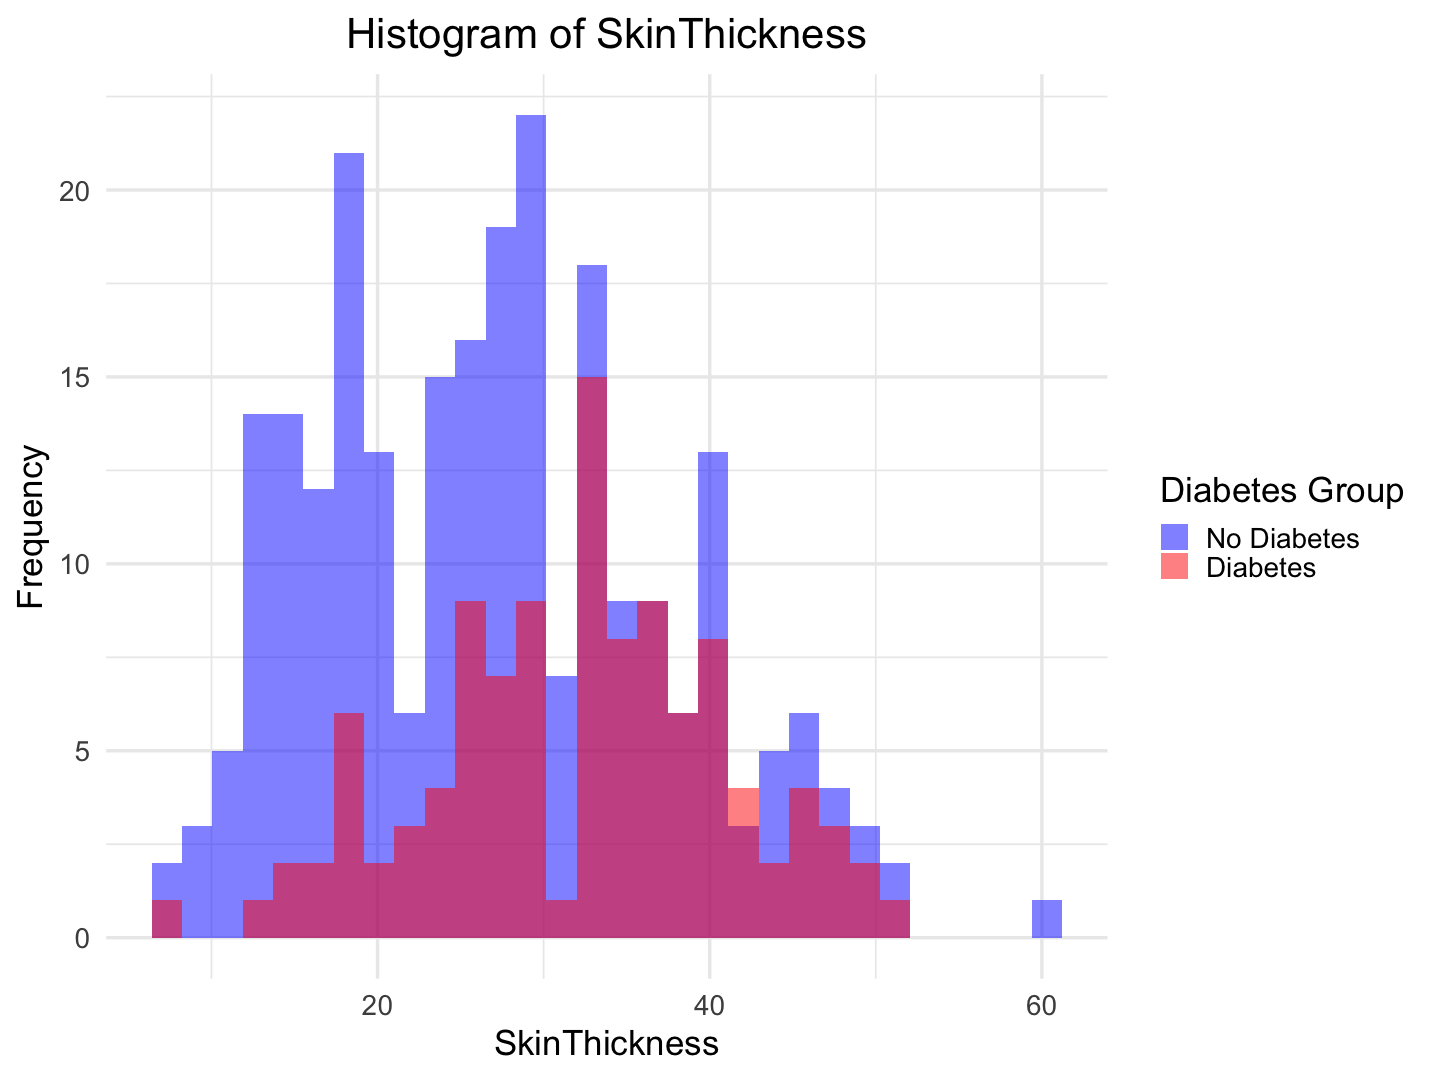

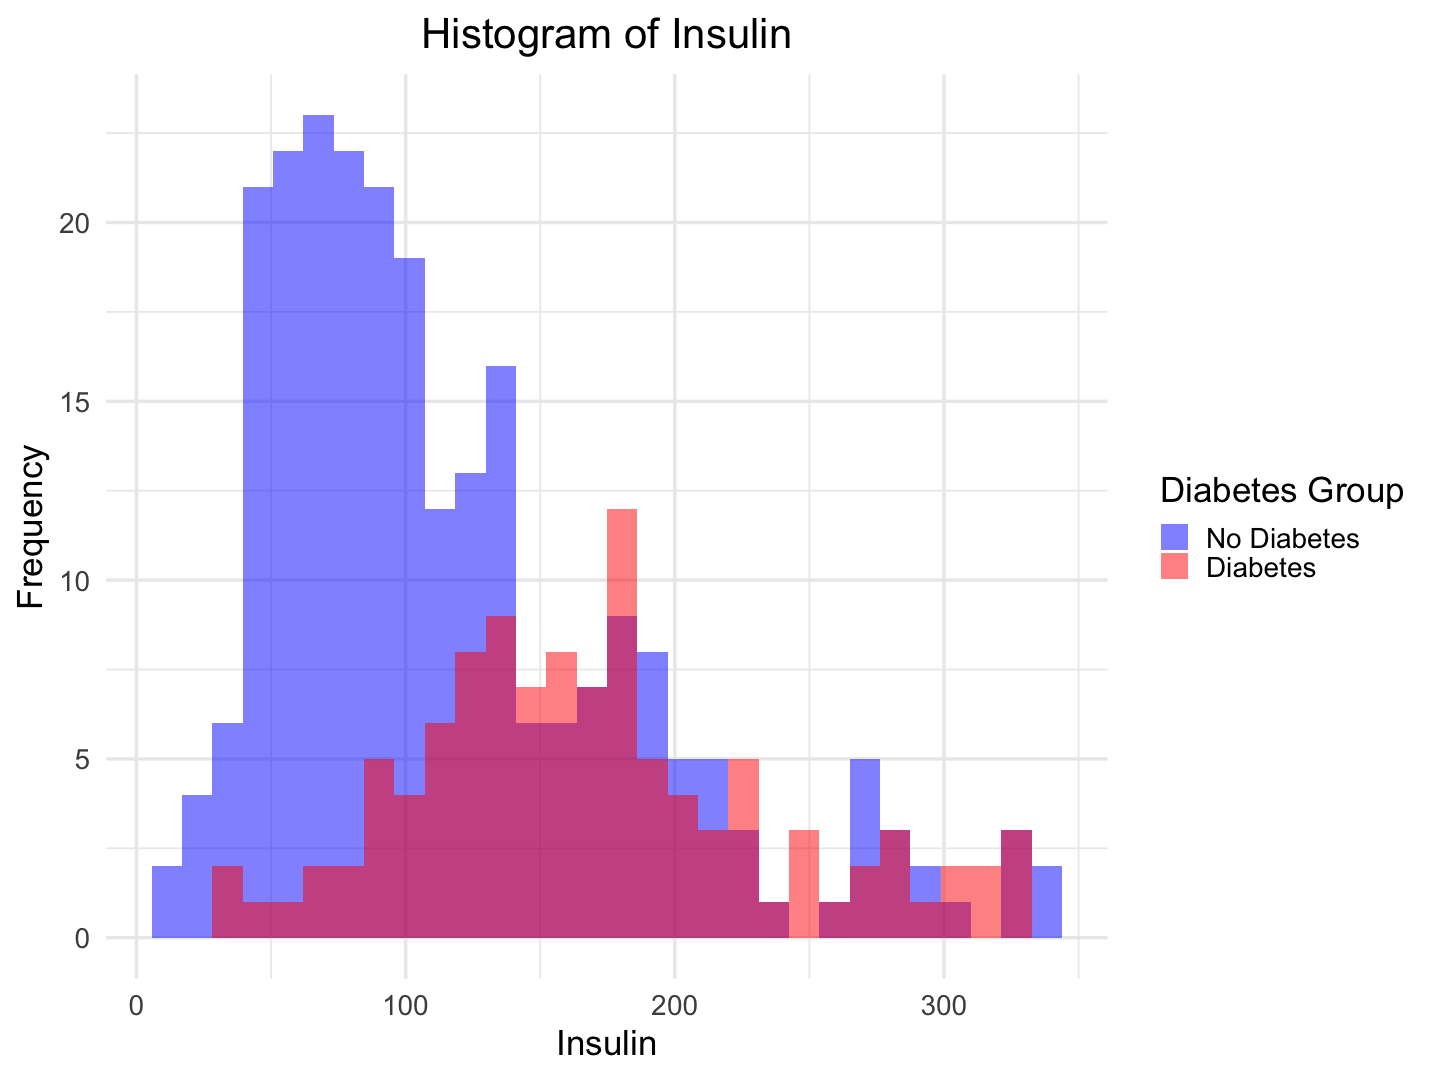

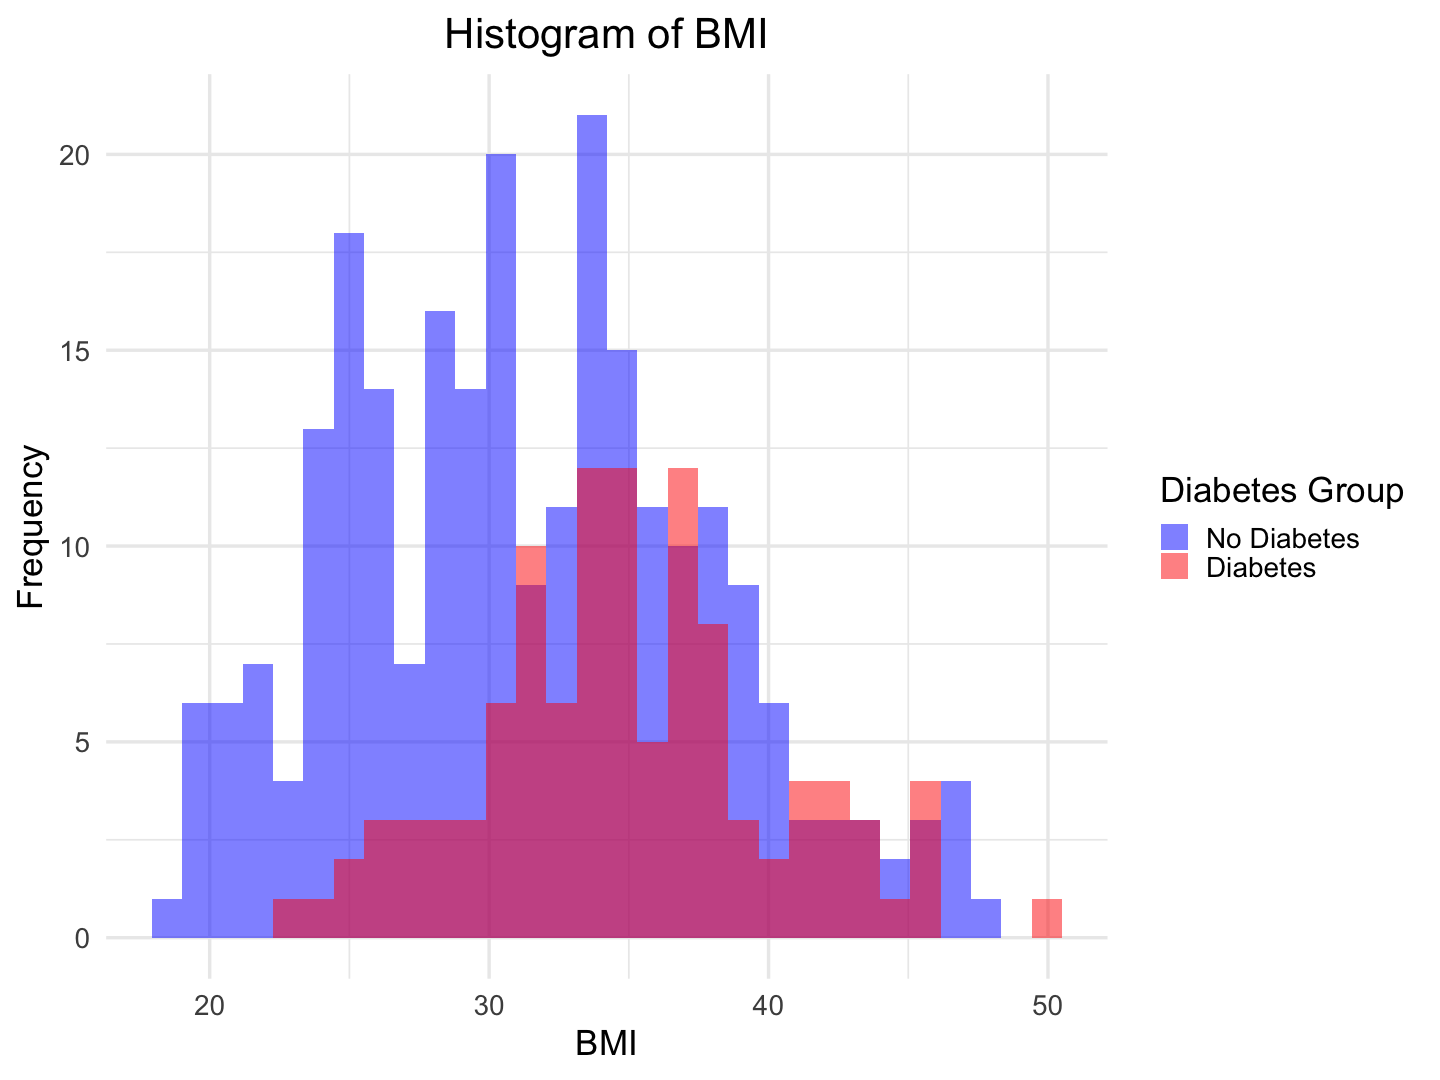

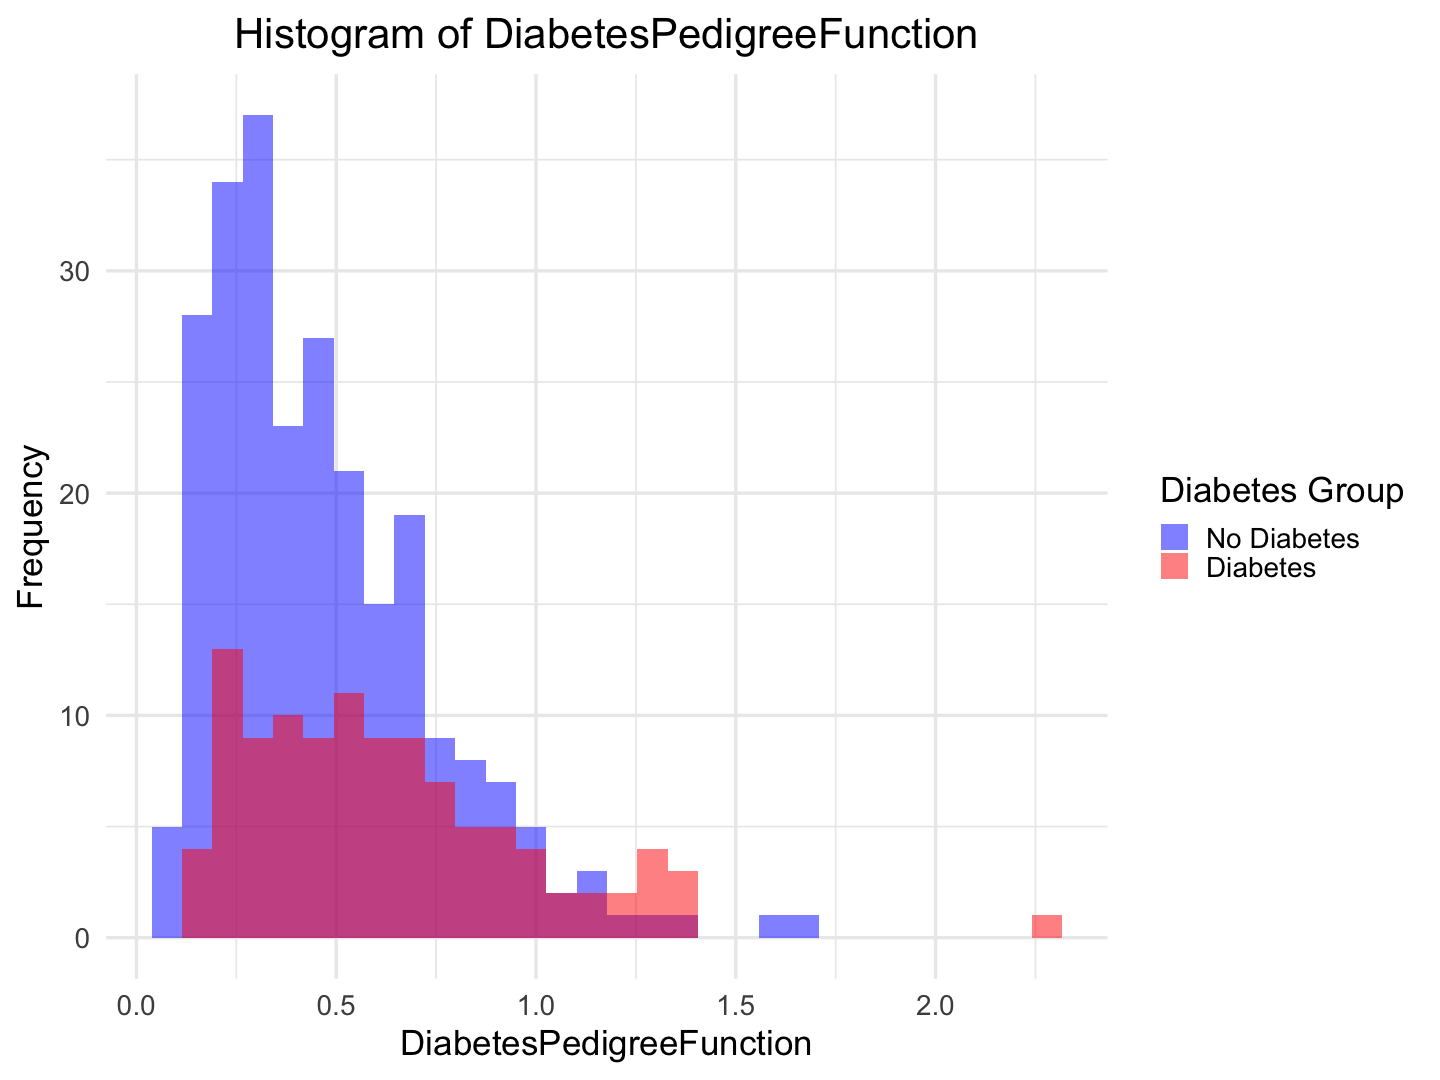

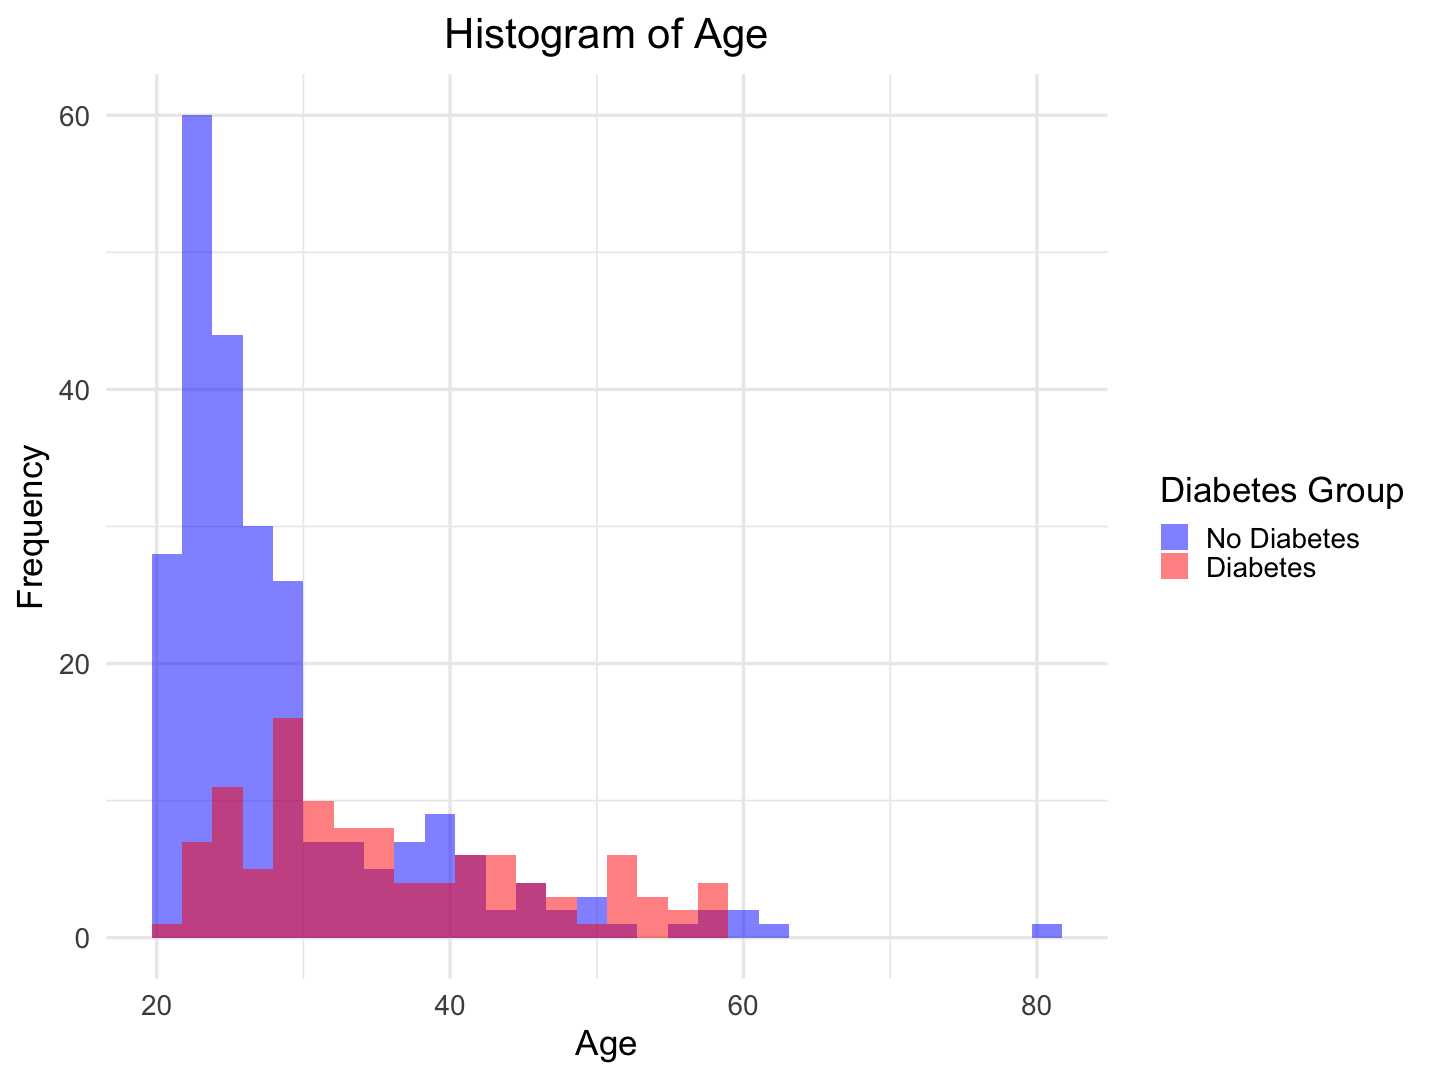

In [9]:
# Main developer: Yulin 
options(repr.plot.width = 12, repr.plot.height = 9)

numeric_cols <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

for (feat in numeric_cols) {
  feat_plot <- ggplot(diabetes_clean) + 
    geom_histogram(aes(x = get(feat), fill = Outcome), bins = 30, alpha = 0.5, position = "identity") +
    labs(title = paste("Histogram of", feat), x = feat, y = "Frequency") +
    scale_fill_manual(values = c("blue", "red"), labels = c("No Diabetes", "Diabetes")) +
    guides(fill = guide_legend(title = "Diabetes Group")) +
    theme_minimal(base_size = 21) + 
    theme(plot.title = element_text(hjust = 0.5))
  
  print(feat_plot)
}

## Methods: Plan

In [10]:
# Main developer: Yulin 

set.seed(123)

diabetes_sample <-
    diabetes_clean %>%
    mutate(id = row_number())

training_diabetes <- 
    diabetes_sample %>%
    slice_sample(prop = 0.70)

testing_diabetes <- 
    diabetes_sample %>% 
    anti_join(training_diabetes, by = "id") %>%
    select(-id)

training_diabetes <-
    training_diabetes |>
    select(-id)

weights <- ifelse(training_diabetes$Outcome == 1,
                  sum(training_diabetes$Outcome == 0) / sum(training_diabetes$Outcome == 1),
                  sum(training_diabetes$Outcome == 1) / sum(training_diabetes$Outcome == 0))

In [11]:
# Main developer: Yulin 

set.seed(123)

diabetes_X_train <- model.matrix(object = Outcome ~ .,
  data = training_diabetes)[, -1]

diabetes_Y_train <- as.matrix(training_diabetes[, "Outcome"])

diabetes_X_test <- model.matrix(object = Outcome ~ .,
  data = testing_diabetes)[, -1]

diabetes_Y_test <- as.matrix(testing_diabetes[, "Outcome"])

In [12]:
# Main developer: Yulin 

set.seed(123)

diabetes_logistic_model <- 
    glm(
        formula = Outcome ~ .,
        data = training_diabetes,
        family = binomial,
        weights = weights)

ROC_full_log <- 
    roc(
        response = training_diabetes$Outcome, 
        predictor = predict(diabetes_logistic_model, type = "response"))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [13]:
# Main developer: Yulin 

set.seed(123)

num.folds <- 10
folds <- createFolds(training_diabetes$Outcome, k = num.folds)

auc.cv <- numeric(num.folds)

for (fold in 1:num.folds) {
  train_data <- training_diabetes[-folds[[fold]], ]
  test_data <- training_diabetes[folds[[fold]], ]
  
  model <- glm(Outcome ~ ., data = train_data, family = "binomial")
  
  predictions <- predict(model, newdata = test_data, type = "response")
  
  auc.cv[fold] <- roc(test_data$Outcome, predictions)$auc
}

diabetes_cv_ordinary <- round(mean(auc.cv), 7)

cat("Cross-validation AUC for the ordinary logistic model:", 
diabetes_cv_ordinary)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the ordinary logistic model: 0.8581874

In [14]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    tibble(
        model = "ordinary",
        auc = diabetes_cv_ordinary)

diabetes_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.8581874


In [15]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_ridge <- 
    cv.glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        type.measure = "auc",
        nfolds = 10)

diabetes_cv_lambda_ridge


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, weights = weights,      type.measure = "auc", nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.05    91  0.8254 0.03623       8
1se 197.60     2  0.8126 0.04508       8

In [16]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.1se, 4)

print(paste("The lambda_min in Ridge Regression:", diabetes_cv_lambda_max_AUC_ridge))
print(paste("The lambda_1se in Ridge Regression:", diabetes_cv_lambda_1se_AUC_ridge))

[1] "The lambda_min in Ridge Regression: 0.0501"
[1] "The lambda_1se in Ridge Regression: 197.596"


In [17]:
# Main developer: Yulin 

set.seed(123)

diabetes_ridge_max_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_max_AUC_ridge)

diabetes_ridge_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_1se_AUC_ridge)

coef(diabetes_ridge_max_AUC)
coef(diabetes_ridge_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -7.478520731
Pregnancies               0.067292007
Glucose                   0.024538186
BloodPressure             0.012379271
SkinThickness             0.007447028
Insulin                   0.003165661
BMI                       0.055684590
DiabetesPedigreeFunction  1.056561986
Age                       0.030230395

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              8.821468e-01
Pregnancies              1.446721e-04
Glucose                  3.408961e-05
BloodPressure            3.488449e-05
SkinThickness            4.336500e-05
Insulin                  1.163695e-05
BMI                      1.001328e-04
DiabetesPedigreeFunction 1.032969e-03
Age                      7.496753e-05

In [18]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "ridge_lambda_min", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index[1]]) |>
    add_row(model = "ridge_lambda_1se", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index["1se",]])

diabetes_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.8581874
ridge_lambda_min,0.8254444
ridge_lambda_1se,0.8126127


In [19]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_LASSO <- cv.glmnet(
    x = diabetes_X_train, y = diabetes_Y_train,
    alpha = 1,
    family = "binomial",
    weights = weights,
    type.measure = "auc",
    nfolds = 10
)

diabetes_cv_lambda_LASSO


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, weights = weights,      type.measure = "auc", nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.00694    38  0.8304 0.03464       7
1se 0.07794    12  0.7960 0.04150       3

In [20]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.1se, 4)

print(paste("The lambda_min in LASSO Regression:", diabetes_cv_lambda_max_AUC_LASSO))
print(paste("The lambda_1se in LASSO Regression:", diabetes_cv_lambda_1se_AUC_LASSO))

[1] "The lambda_min in LASSO Regression: 0.0069"
[1] "The lambda_1se in LASSO Regression: 0.0779"


In [21]:
# Main developer: Yulin 

set.seed(123)

diabetes_LASSO_max_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_max_AUC_LASSO)

diabetes_LASSO_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_1se_AUC_LASSO)

coef(diabetes_LASSO_max_AUC)
coef(diabetes_LASSO_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)              -9.8080230301
Pregnancies               0.0818049944
Glucose                   0.0386713147
BloodPressure             0.0097717724
SkinThickness             .           
Insulin                   0.0004619684
BMI                       0.0865142061
DiabetesPedigreeFunction  1.5620069334
Age                       0.0318816242

9 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
(Intercept)              -3.06376988
Pregnancies               .         
Glucose                   0.02161828
BloodPressure             .         
SkinThickness             .         
Insulin                   .         
BMI                       0.02105365
DiabetesPedigreeFunction  .         
Age                       0.01443170

In [22]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "lasso_lambda_min", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index[1]]) |>
    add_row(model = "lasso_lambda_1se", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index["1se",]])

diabetes_AUC_models

model,auc
<chr>,<dbl>
ordinary,0.8581874
ridge_lambda_min,0.8254444
ridge_lambda_1se,0.8126127
lasso_lambda_min,0.8303976
lasso_lambda_1se,0.7959658


In [23]:
# Main developer: Yulin 

ROC_lasso_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_lasso_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ordinary <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_logistic_model,
                      newdata = testing_diabetes))



Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



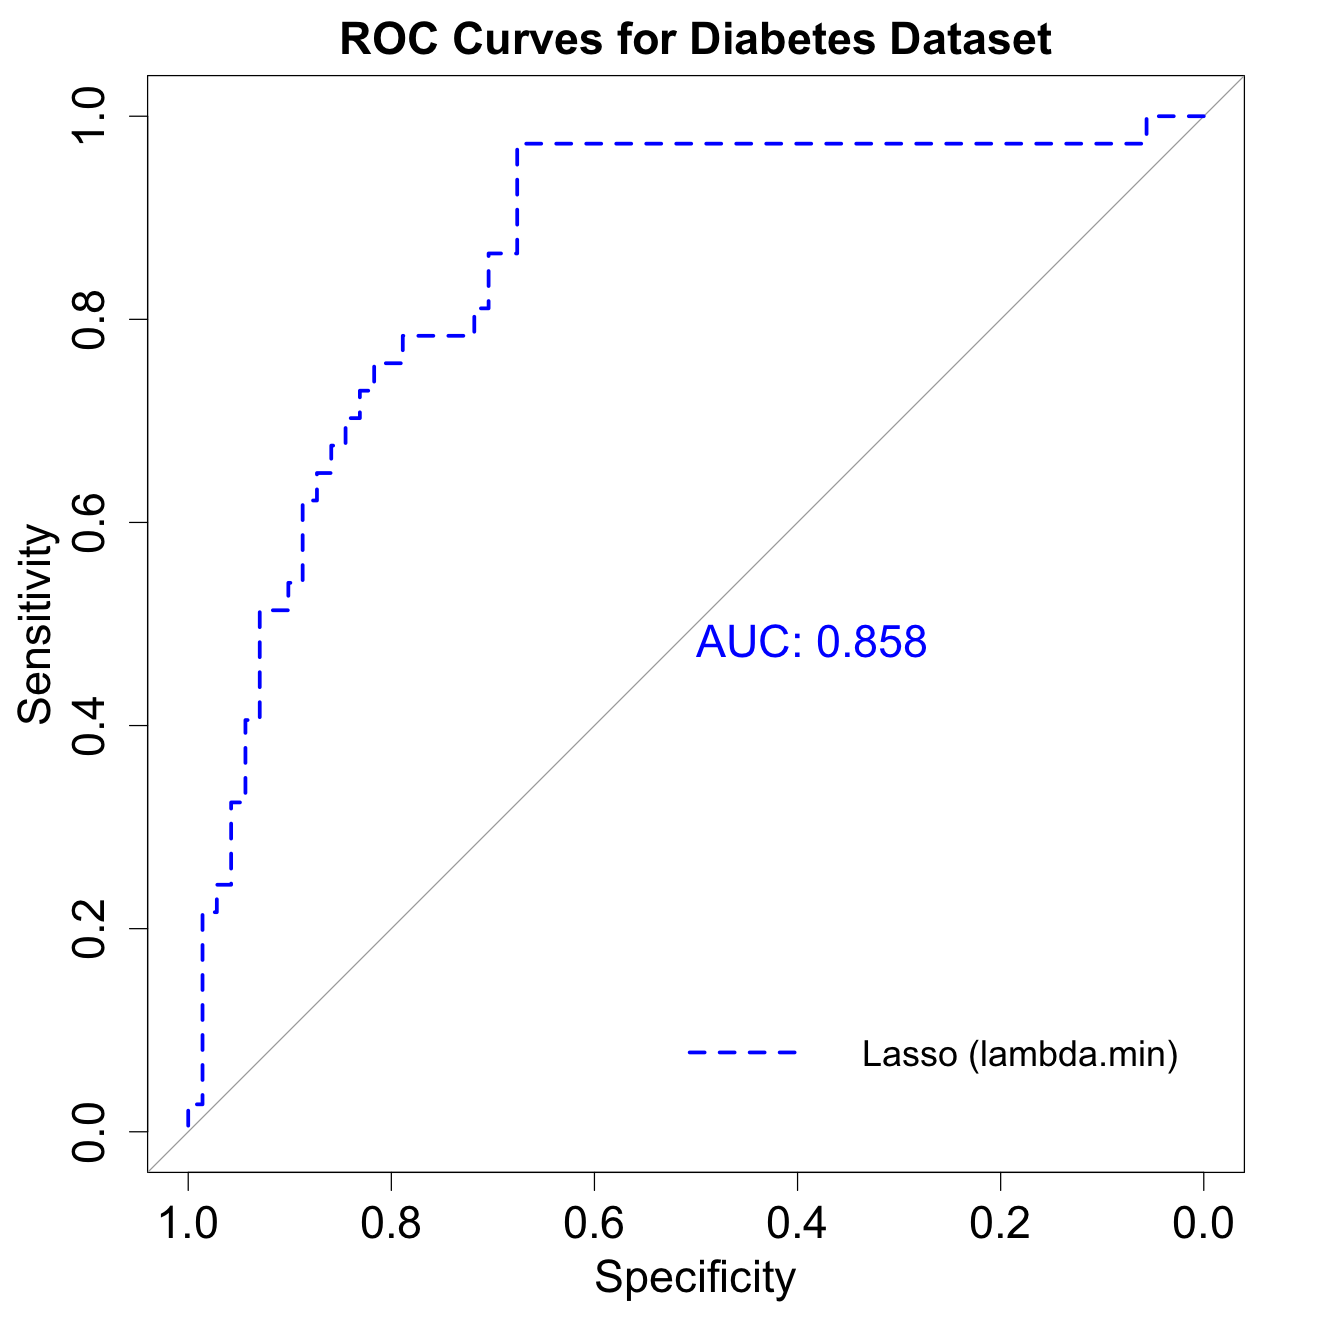

In [24]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_min,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.min)",
       col = "blue", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

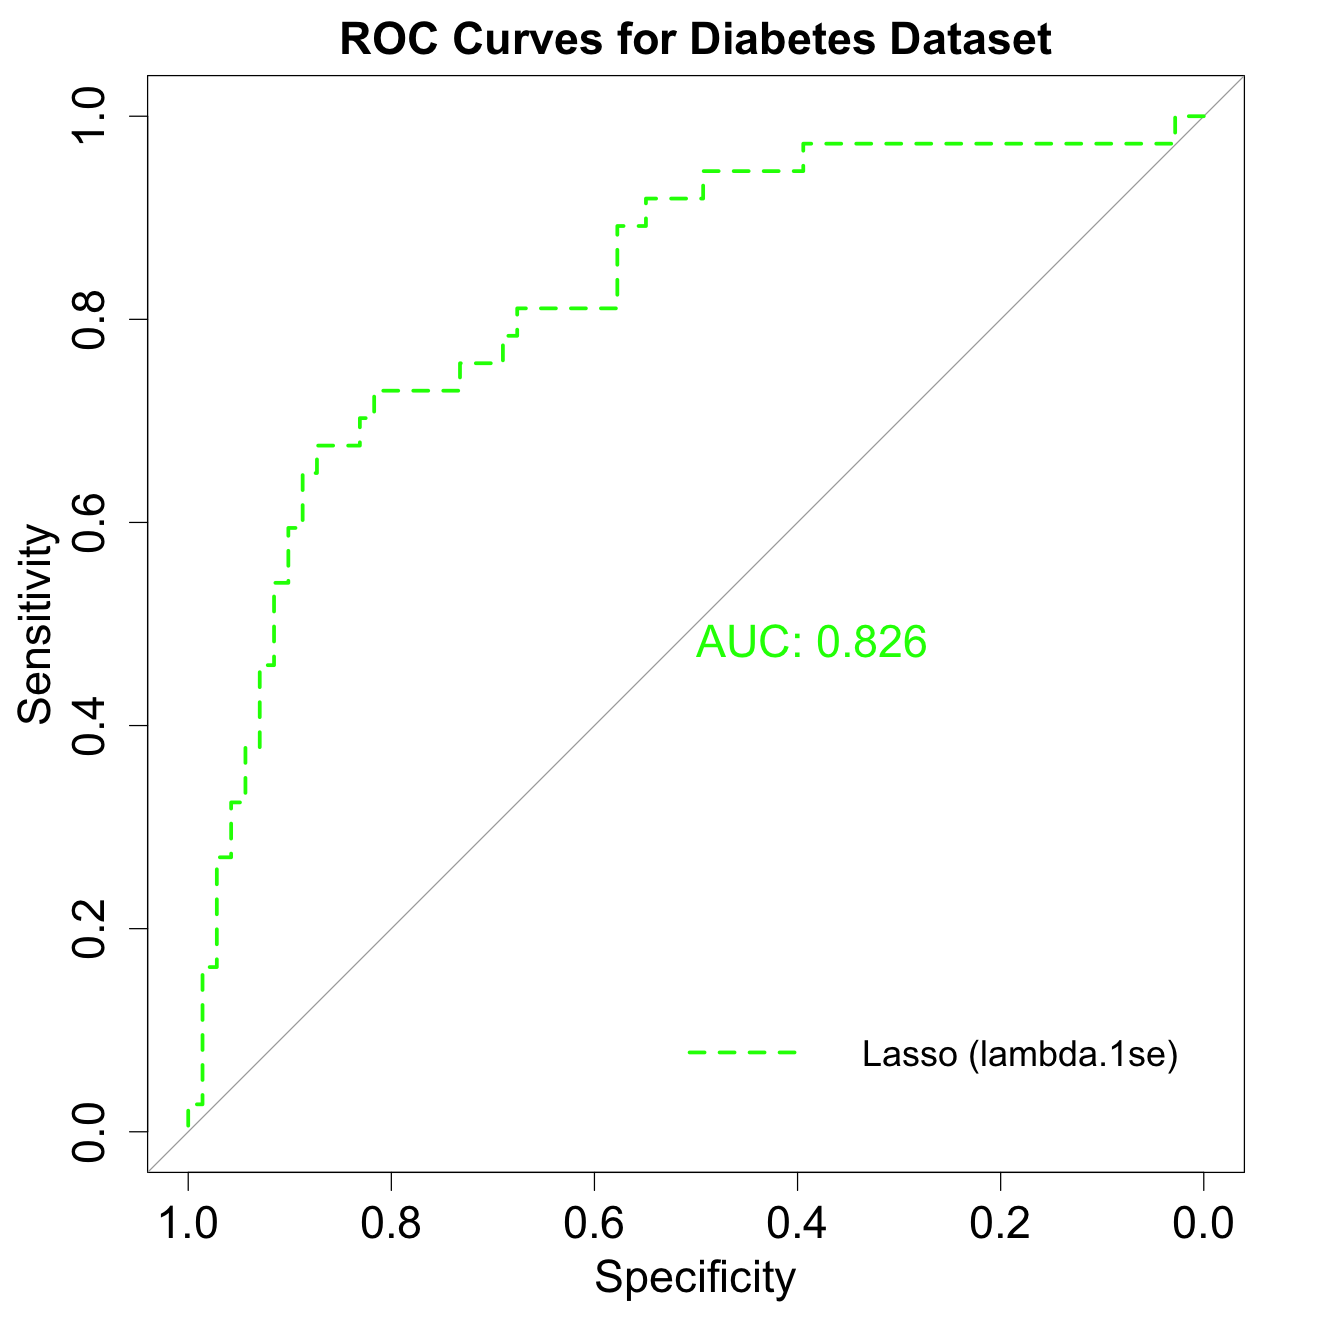

In [25]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_1se,
  print.auc = TRUE, col = "green", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.1se)",
       col = "green", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

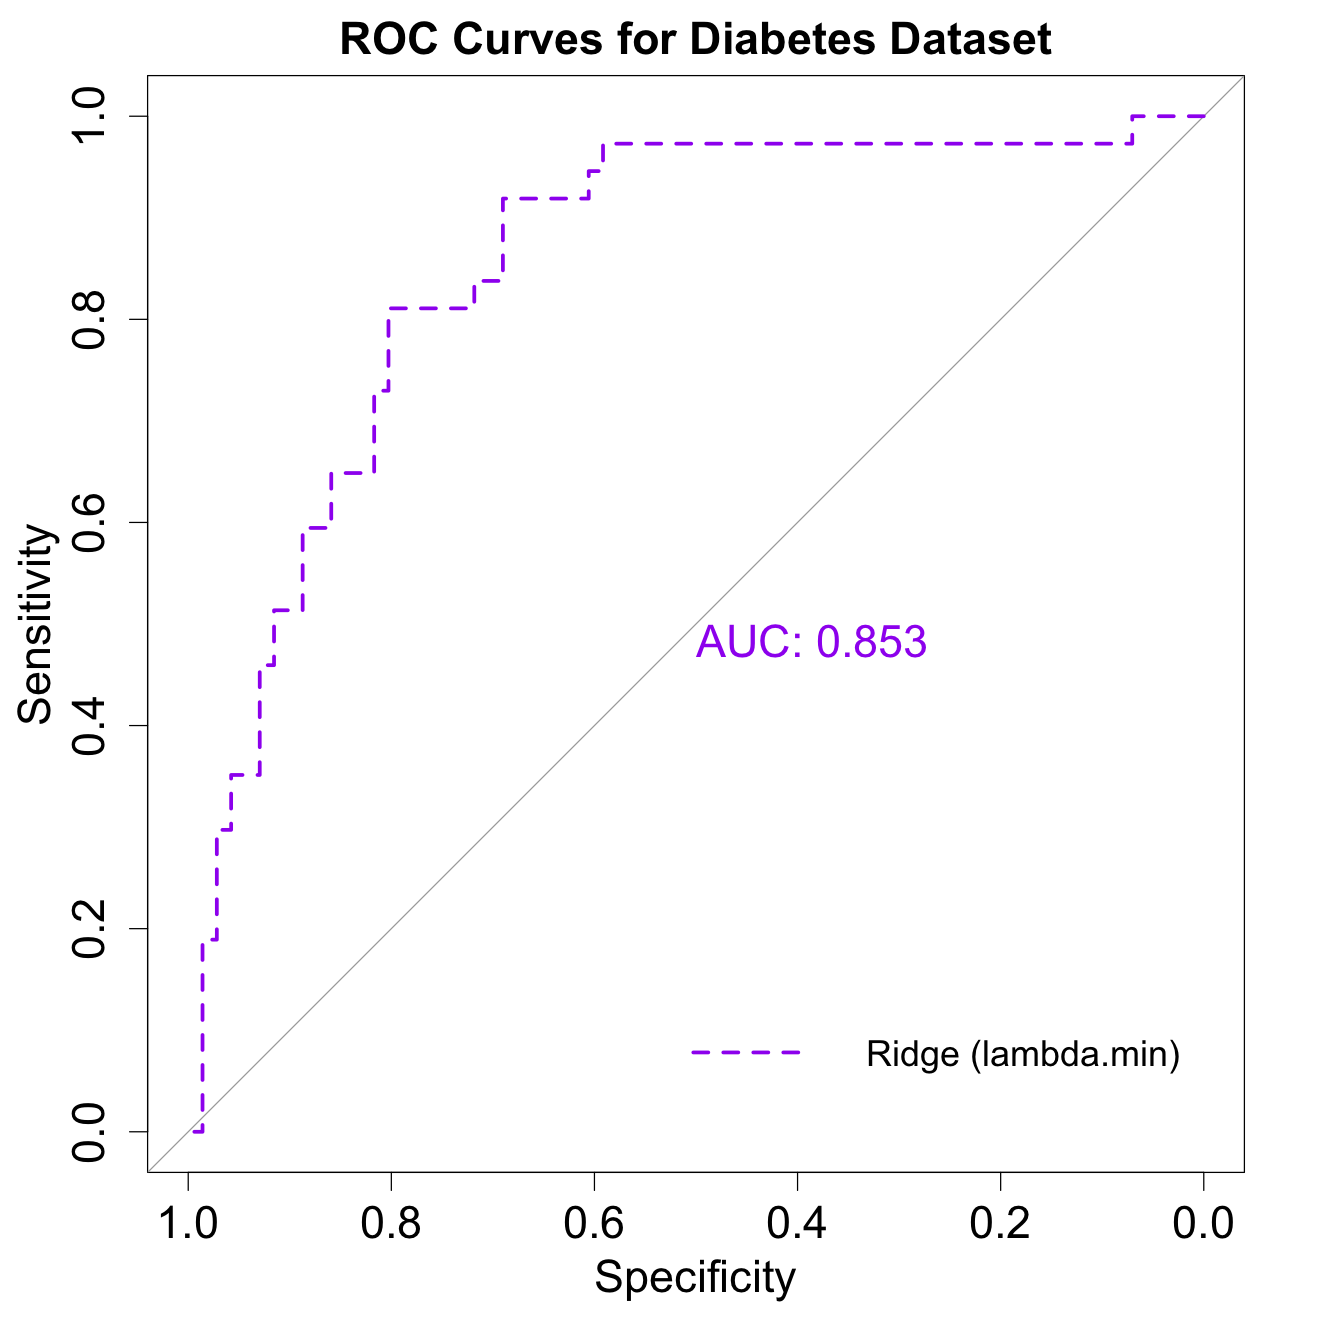

In [26]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_ridge_lambda_min,
  print.auc = TRUE, col = "purple", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Ridge (lambda.min)",
       col = "purple", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

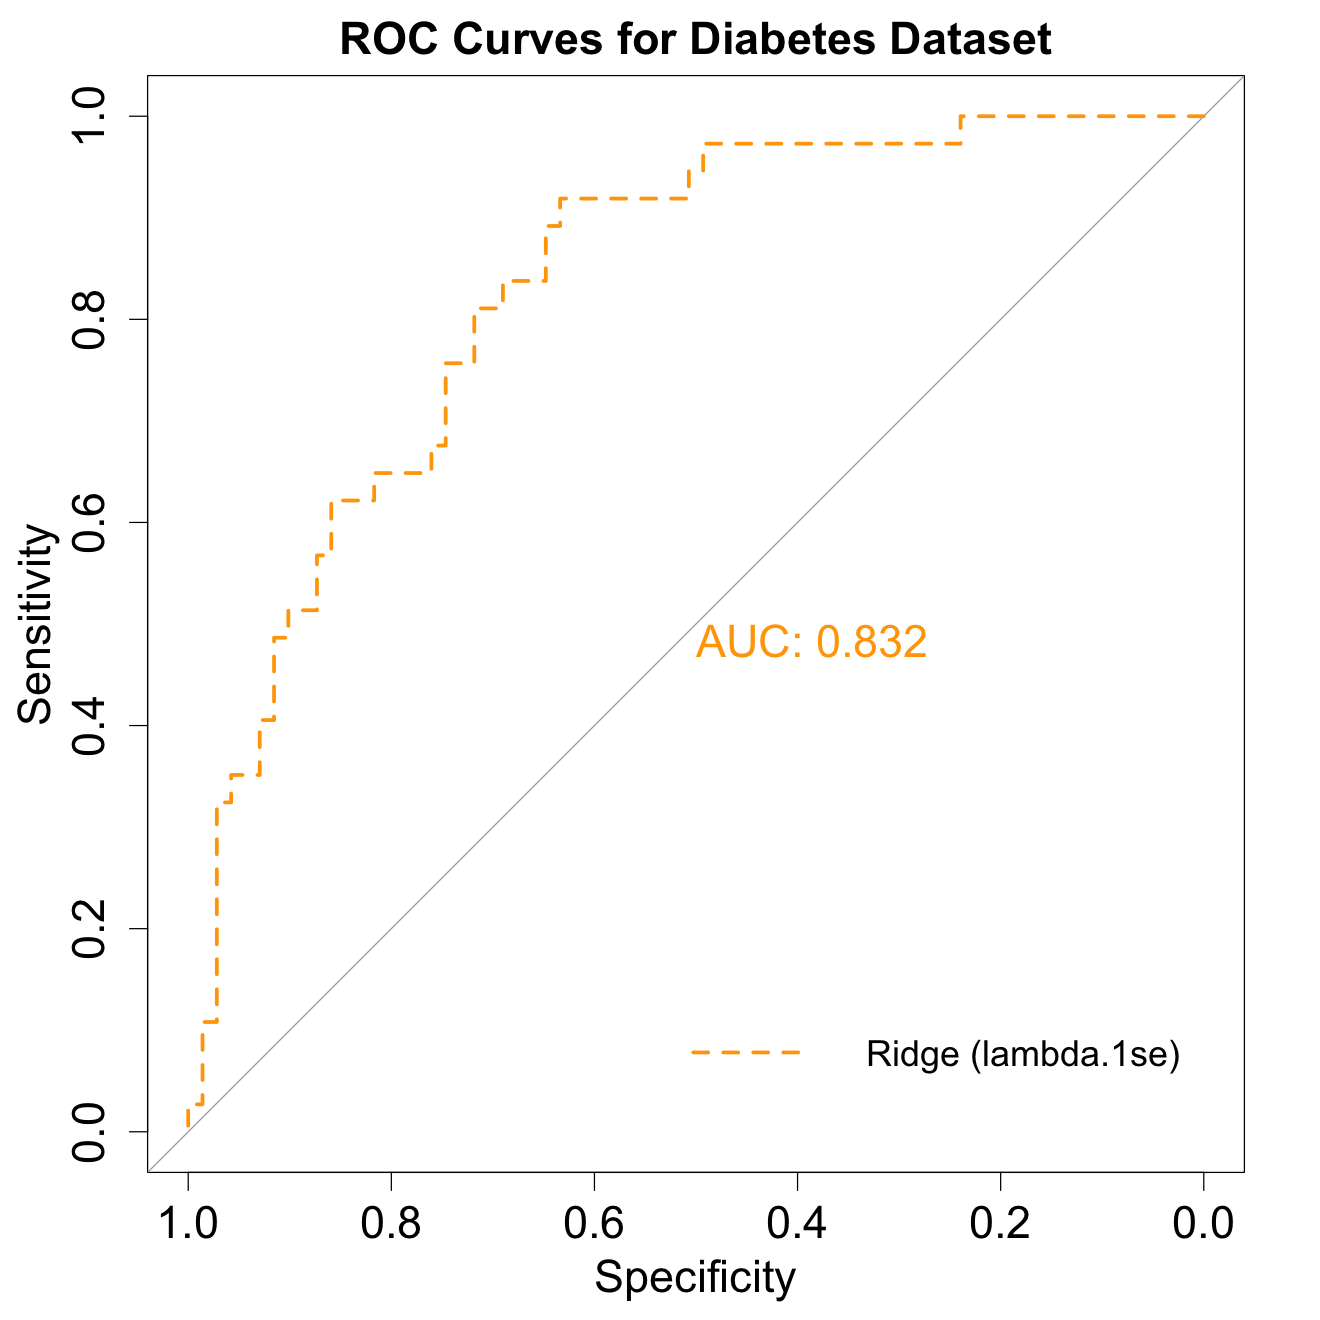

In [27]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_ridge_lambda_1se,
  print.auc = TRUE, col = "orange", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Ridge (lambda.1se)",
       col = "orange", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

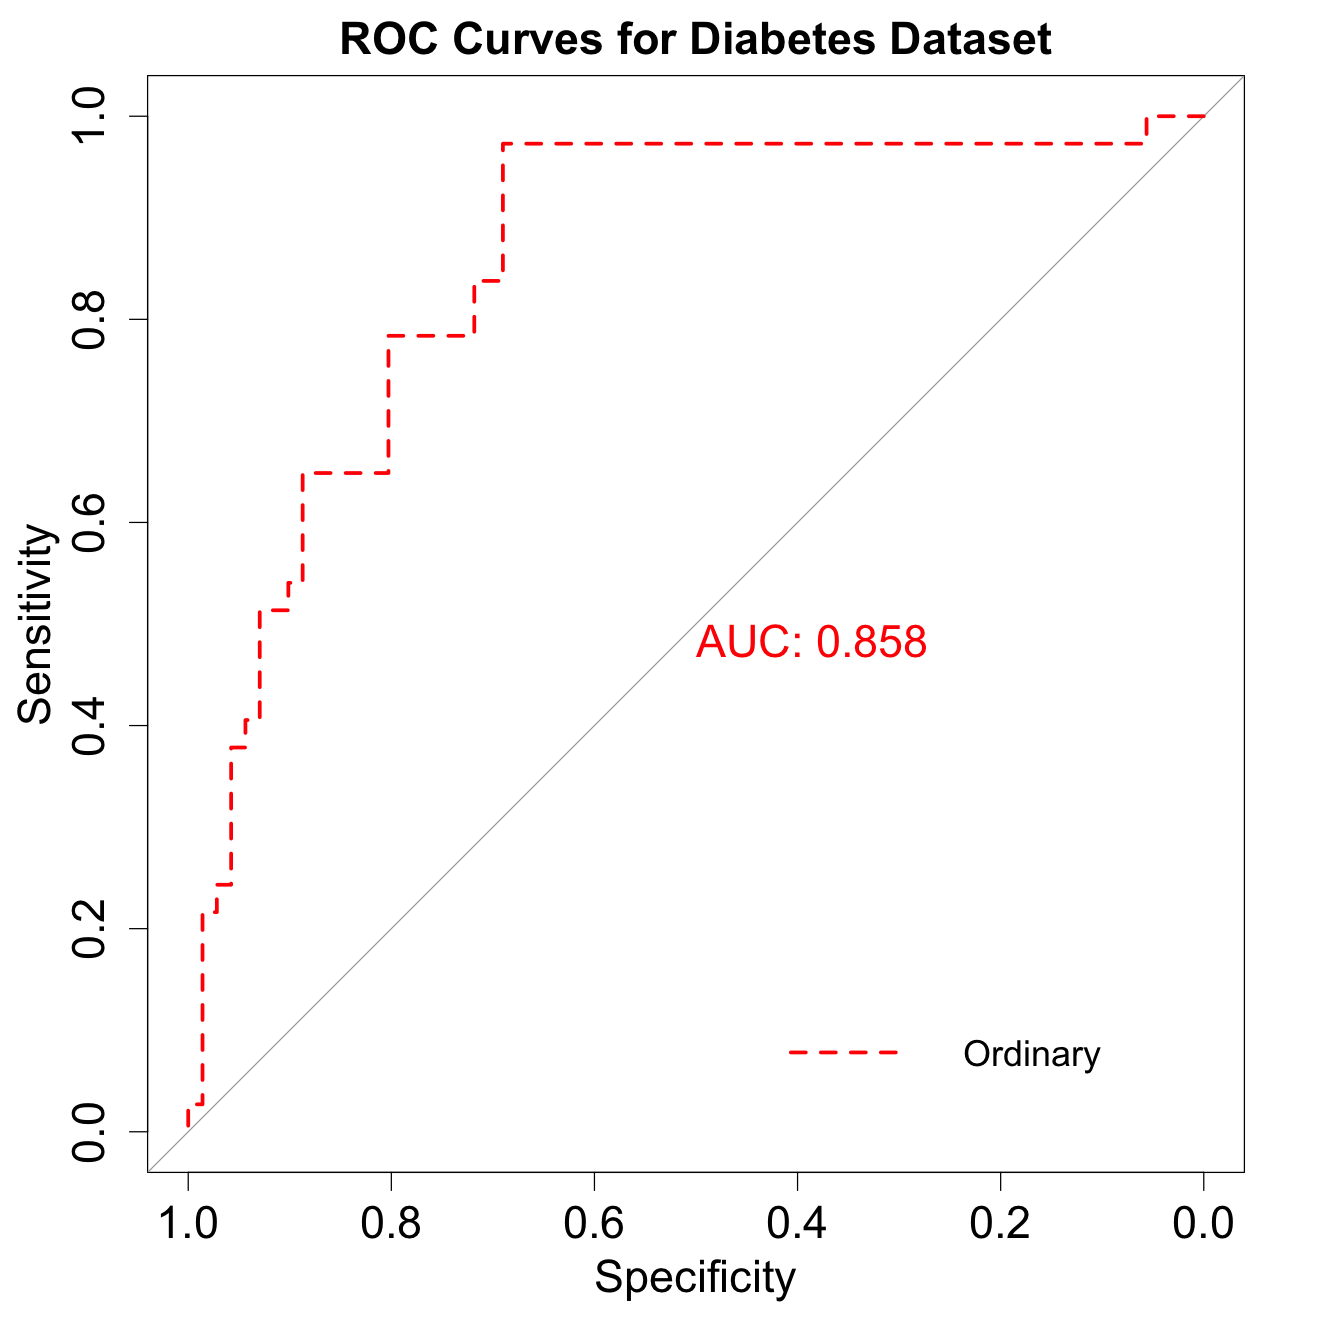

In [28]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_ordinary,
  print.auc = TRUE, col = "red", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", legend = "Ordinary",
       col = "red", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

# Discussion

# References